In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

In [155]:
# Load the dataset into a DataFrame
df = pd.read_csv("train.csv")

# Display the first few rows of the dataset to get an overview
df.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [156]:
# Check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [157]:
# Get summary statistics for numerical columns
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [158]:
# Check for missing values in each column
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [159]:
# only 6000 rows with nan, for now we will drop them and later see what to do.
df.dropna(inplace=True)

# Replace 'f' with 'female' and 'm' with 'male' in the 'gender' column
df['gender'] = df['gender'].replace({'f': 'female', 'm': 'male'})

In [160]:
#extract the number from the region
df['region'] = df['region'].str.extract('(\d+)').astype(int)

*The plot below reveals that the data is imbalanced, with an unequal distribution between the classes. To improve model performance, we will later apply techniques to balance the class distribution.*

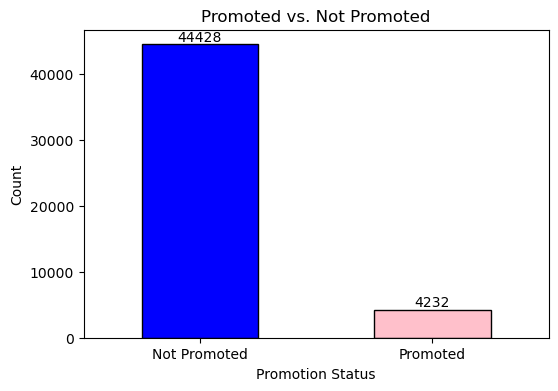

In [161]:
# Count the number of promoted and not-promoted employees
promotion_counts = df['is_promoted'].value_counts()

# Plot a bar chart
plt.figure(figsize=(6, 4))
promotion_counts.plot(kind='bar', color=['blue', 'pink'], linewidth=1, edgecolor="black")
plt.title("Promoted vs. Not Promoted")
plt.xlabel("Promotion Status")
plt.ylabel("Count")

# Add labels to the bars
for i, count in enumerate(promotion_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

# Set custom labels and positions for x-axis ticks
plt.xticks(ticks=[0, 1], labels=['Not Promoted', 'Promoted'], rotation=0)

plt.show()

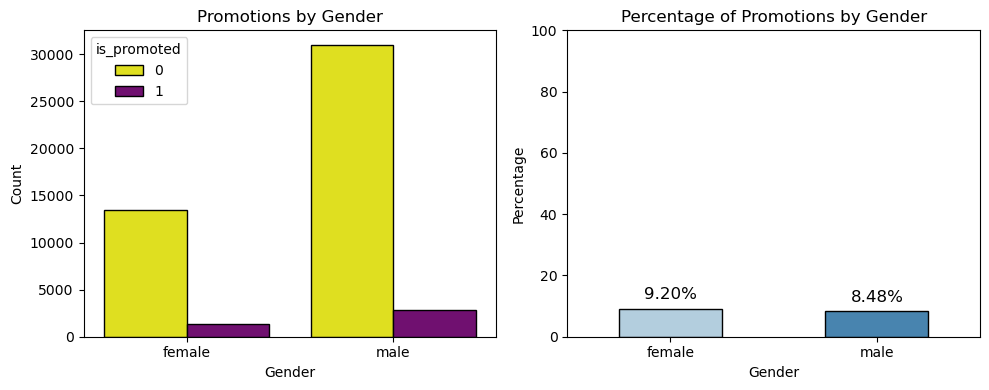

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Create a DataFrame with promotions and not promoted counts by gender
gender_counts = df.groupby(['gender', 'is_promoted'])['employee_id'].count().reset_index()

sns.barplot(x='gender', y='employee_id', hue='is_promoted', data=gender_counts,ax=axes[0] ,palette=["yellow","purple"], linewidth=1, edgecolor="black")
axes[0].set_title("Promotions by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Count")

# Calculate the percentage of promotions by gender
gender_promotion_count = df.groupby('gender')['is_promoted'].value_counts().unstack()
promotion_percentages = gender_promotion_count[1] / (gender_promotion_count[1] + gender_promotion_count[0]) * 100

# Plot a bar chart
sns.barplot(x=promotion_percentages.index, y=promotion_percentages.values, ax=axes[1],palette="Blues", width=0.5,linewidth=1, edgecolor="black")
axes[1].set_title("Percentage of Promotions by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Percentage")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

# Annotate the bars with percentage values
for index, value in enumerate(promotion_percentages):
    plt.text(index, value + 2, f"{value:.2f}%", ha='center', va='bottom', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

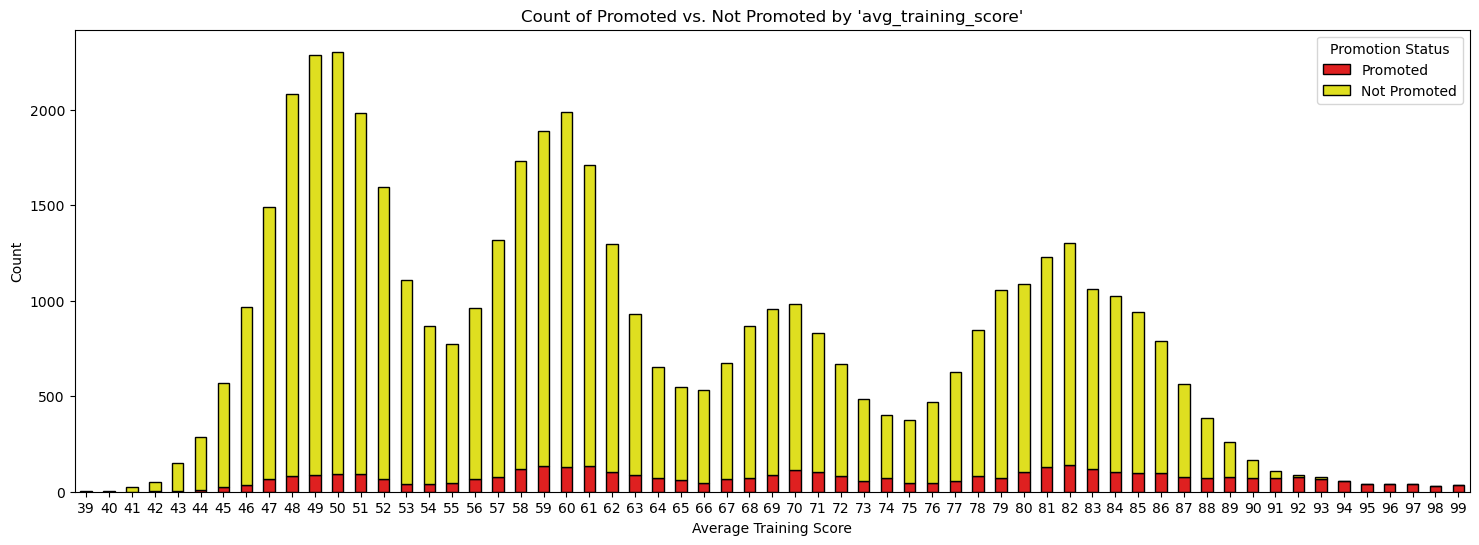

In [163]:
plt.figure(figsize=(18, 6))

score_counts = df.groupby(['avg_training_score', 'is_promoted'])['is_promoted'].count().unstack().fillna(0)

sns.barplot(data=score_counts.reset_index(), x='avg_training_score', y=1, color='red', label='Promoted', width=0.5,linewidth=1, edgecolor="black")
sns.barplot(data=score_counts.reset_index(), x='avg_training_score', y=0, color='yellow', bottom=score_counts[1], label='Not Promoted', width=0.5,linewidth=1, edgecolor="black")
plt.title("Count of Promoted vs. Not Promoted by 'avg_training_score'")
plt.xlabel("Average Training Score")
plt.ylabel("Count")
plt.legend(title="Promotion Status")
plt.show()

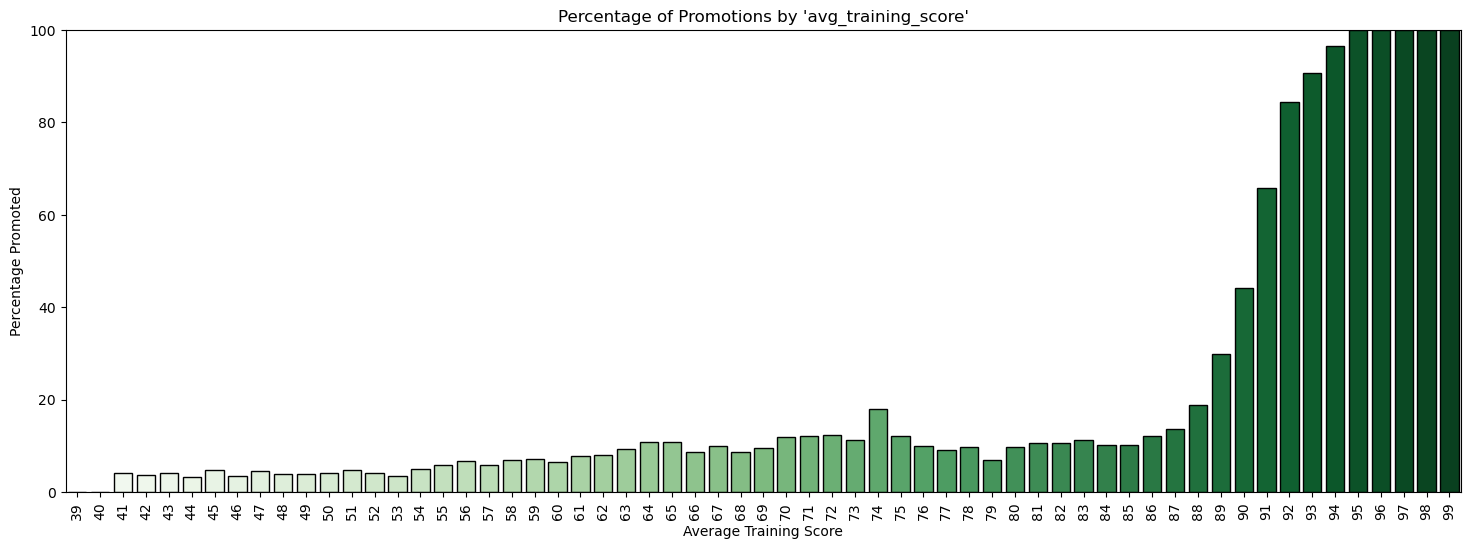

In [164]:
# Group the data by 'avg_training_score' and calculate the percentage of promotions
score_promotion_percentage = df.groupby('avg_training_score')['is_promoted'].mean() * 100

# Plot a bar chart for the percentage of promotions
plt.figure(figsize=(18, 6))
sns.barplot(x=score_promotion_percentage.index, y=score_promotion_percentage.values, palette='Greens',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'avg_training_score'")
plt.xlabel("Average Training Score")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages
plt.xticks(rotation=90)

plt.show()

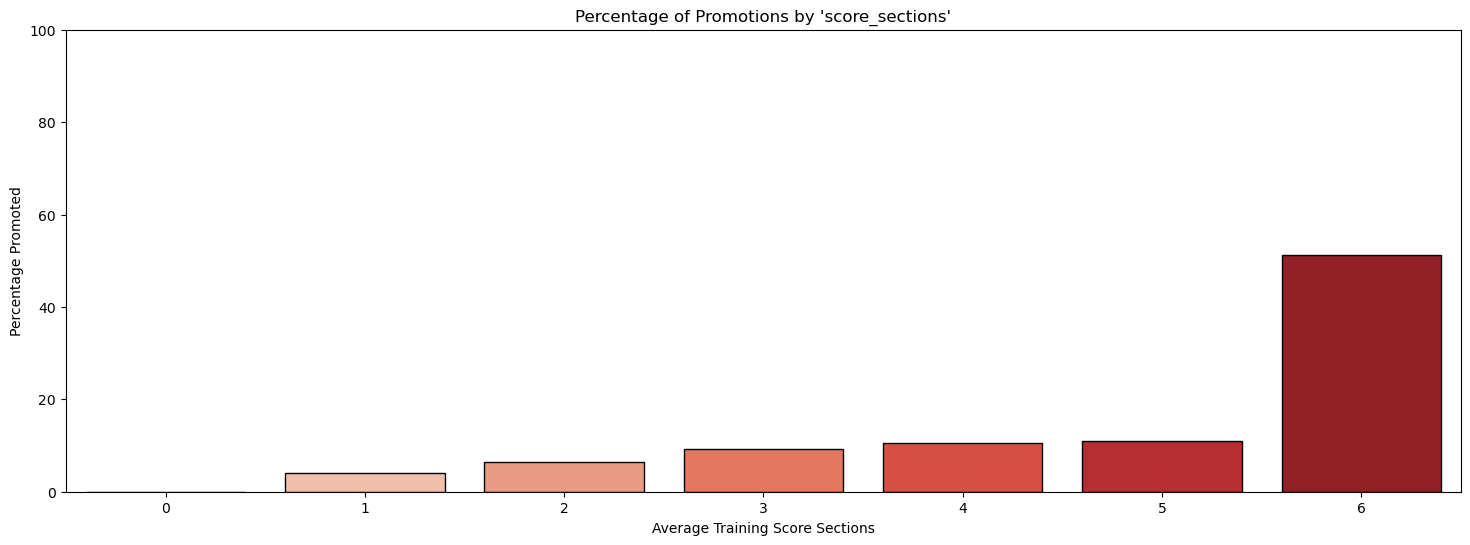

In [165]:
# We will attempt to partition the column into multiple segments.

# Define the bin edges and labels
bin_edges = [0, 40, 53, 60, 70 ,80,87,99]  # Adjust the bin edges as needed
bin_labels = [0, 1, 2, 3, 4, 5, 6]  # Numeric labels for each bin

# Use pd.cut to create sections and map them to numerical values
df['score_sections'] = pd.cut(df['avg_training_score'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Group the data by 'score_sections' and calculate the percentage of promotions
score_promotion_percentage = df.groupby('score_sections')['is_promoted'].mean() * 100

# Plot a bar chart for the percentage of promotions
plt.figure(figsize=(18, 6))
sns.barplot(x=score_promotion_percentage.index, y=score_promotion_percentage.values, palette='Reds',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'score_sections'")
plt.xlabel("Average Training Score Sections")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

plt.show()

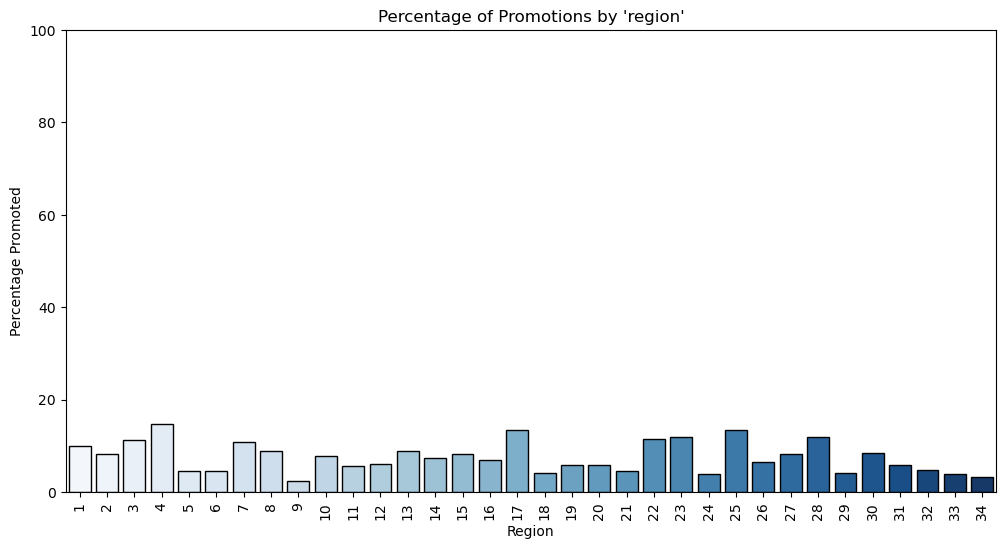

In [166]:
# Group the data by 'region' and calculate the percentage of promotions
region_promotion_percentage = df.groupby('region')['is_promoted'].mean() * 100

# Sort regions by promotion percentage in descending order
region_promotion_percentage = region_promotion_percentage.sort_values(ascending=False)

# Plot a bar chart for the percentage of promotions by region
plt.figure(figsize=(12, 6))
sns.barplot(x=region_promotion_percentage.index, y=region_promotion_percentage.values, palette='Blues',linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by 'region'")
plt.xlabel("Region")
plt.ylabel("Percentage Promoted")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages
plt.xticks(rotation=90)

plt.show()

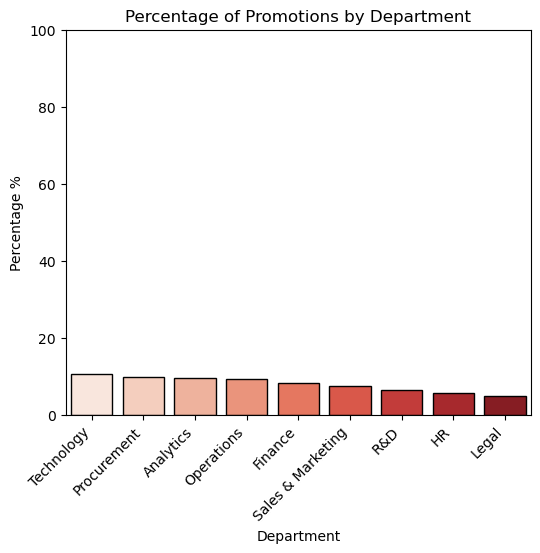

In [167]:
# Calculate the percentage of promotions for each department
department_promotion_percentage = df.groupby('department')['is_promoted'].mean() * 100

# Sort departments by promotion percentage
department_promotion_percentage = department_promotion_percentage.sort_values(ascending=False)

# Plot a bar chart
plt.figure(figsize=(6, 5))
ax = sns.barplot(y=department_promotion_percentage.values, x=department_promotion_percentage.index, palette="Reds", linewidth=1, edgecolor="black")
plt.title("Percentage of Promotions by Department")
plt.xlabel("Department")
plt.ylabel("Percentage %")
plt.ylim(0, 100)  # Set the y-axis limit to show percentages

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [168]:
# rating of departments based on their promotion performance

df['department'] = df['department'].map({'Technology':2, 'Procurement':2, 'Analytics':2 ,
                                        'Operations':2, 'Finance':1,'Sales & Marketing':1,
                                         'R&D':0, 'HR':0, 'Legal':0})

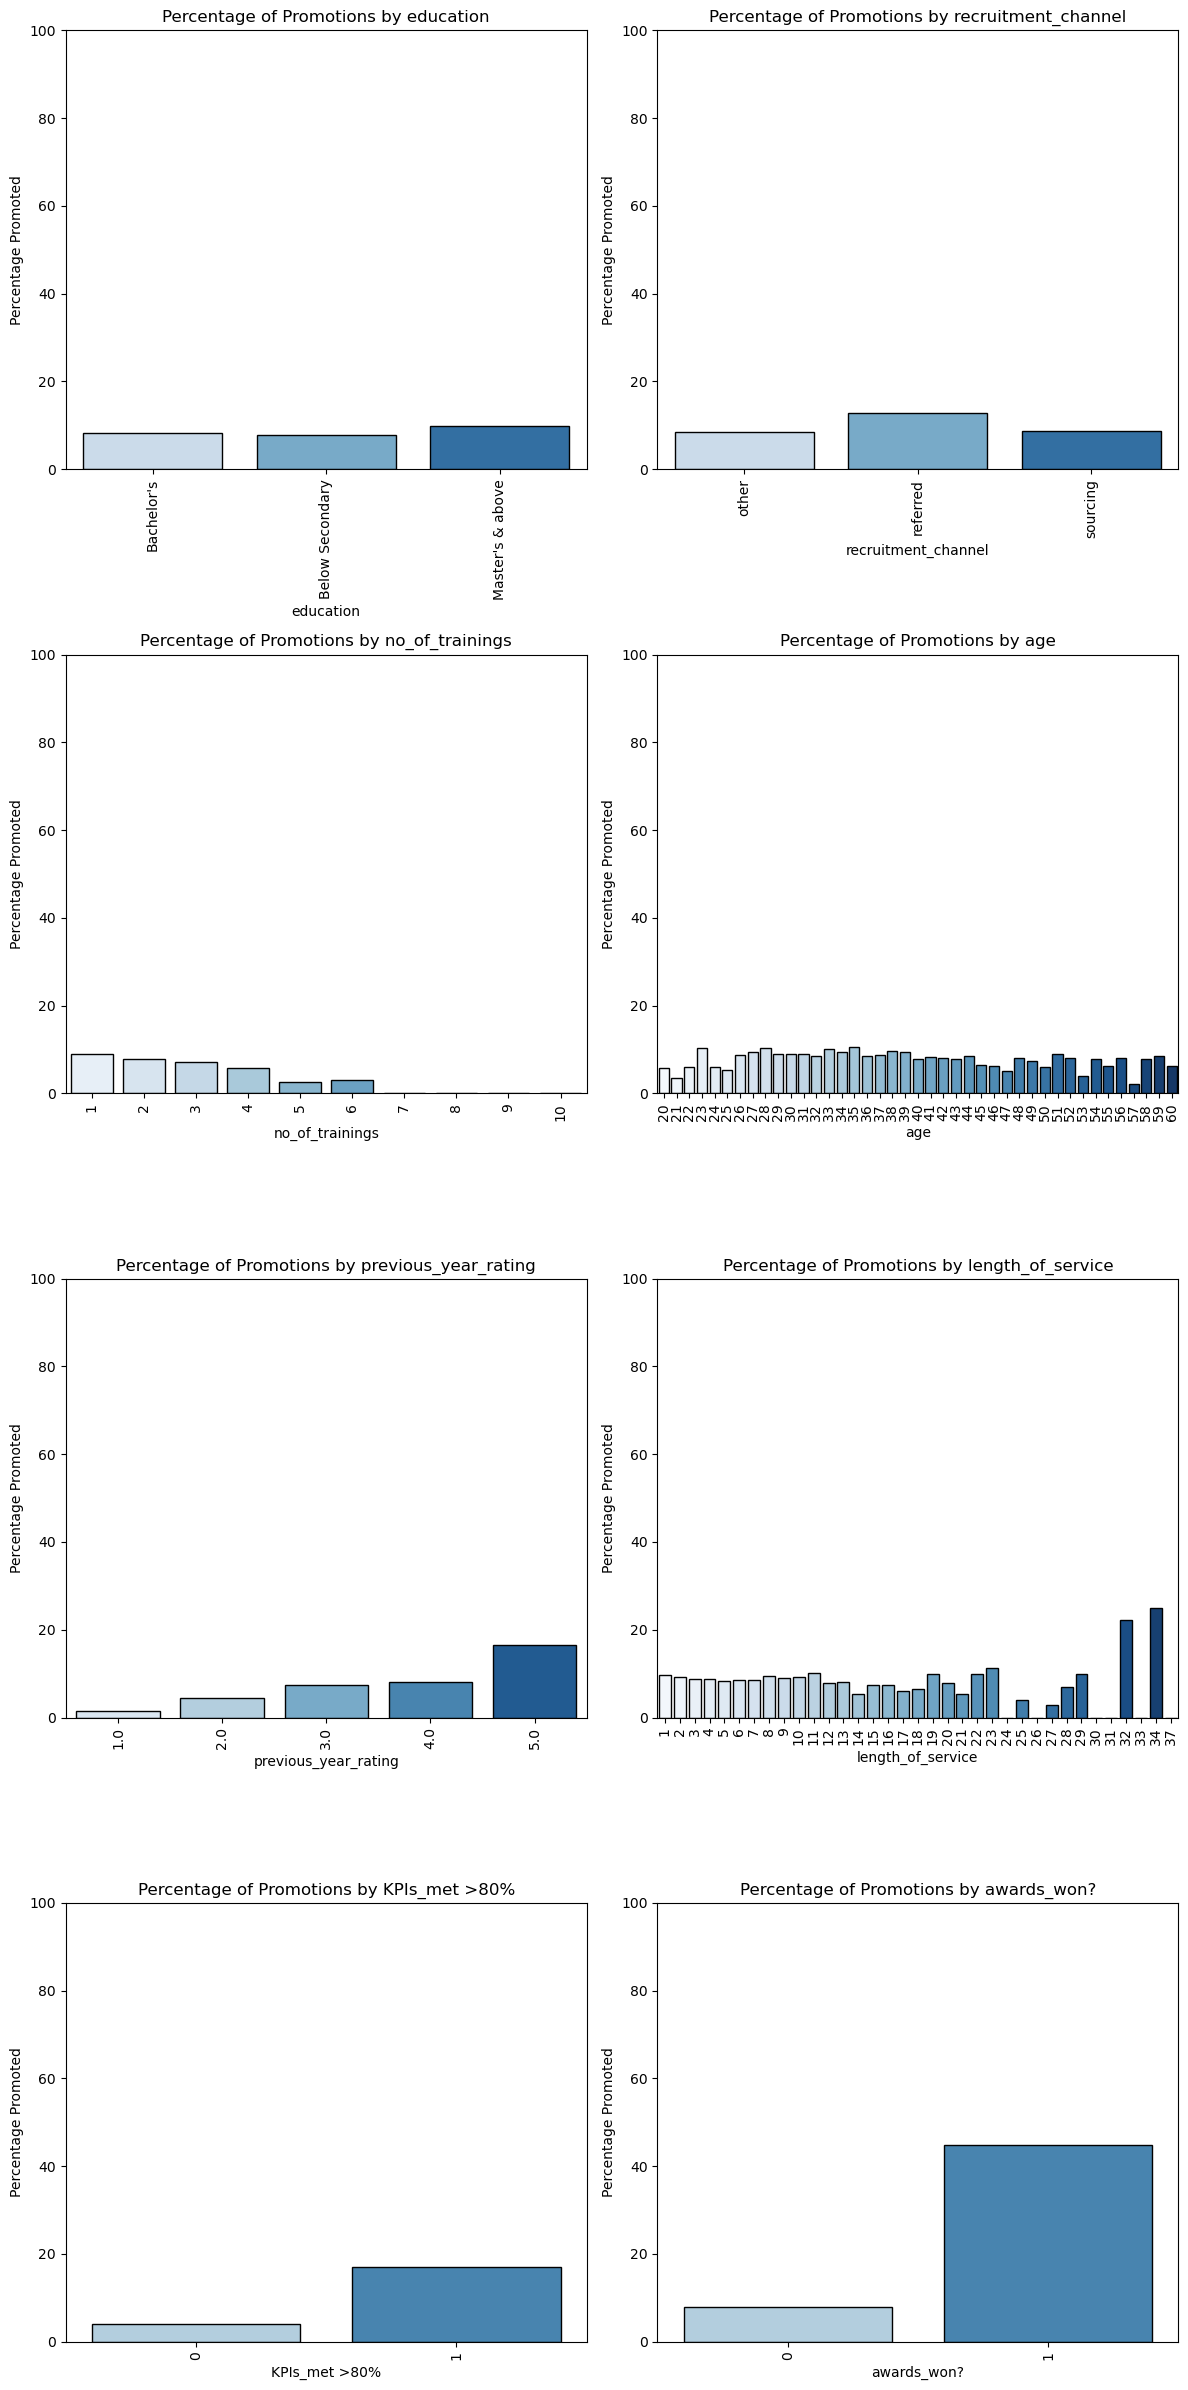

In [169]:
# Specify the columns you want to plot
columns = ['education', 'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
           'length_of_service', 'KPIs_met >80%', 'awards_won?']

# Determine the number of rows and columns for subplots
n_rows = len(columns) // 2  # Divide by 2 to have two plots in each row
n_cols = 2  # Two plots in each row

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))

# Iterate through the specified columns and create plots in rows with two plots in each row
for i, col in enumerate(columns):
    row_index = i // 2  # Determine the row index
    col_index = i % 2   # Determine the column index

    # Group the data by the specified column and calculate the percentage of promotions
    promotion_percentage = df.groupby(col)['is_promoted'].mean() * 100

    # Plot the percentage of promotions on the current axis
    sns.barplot(x=promotion_percentage.index, y=promotion_percentage.values, palette='Blues', ax=axes[row_index, col_index], linewidth=1, edgecolor="black")
    axes[row_index, col_index].set_title("Percentage of Promotions by " + col)
    axes[row_index, col_index].set_xlabel(col)
    axes[row_index, col_index].set_ylabel("Percentage Promoted")
    axes[row_index, col_index].set_ylim(0, 100)  # Set the y-axis limit to show percentages
    axes[row_index, col_index].tick_params(axis='x', rotation=90)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [170]:
# rating of no_of_trainings based on their promotion performance

df['no_of_trainings'] = df['no_of_trainings'].map({1:2, 2:2, 3:2 ,4:2, 
                                                   5:1,6:1,
                                                   7:0, 8:0, 9:0, 10:0})

In [171]:
# Define a custom mapping function
def custom_mapping(value):
    if value in [24,36,30, 31,33 ,37]:
        return 0
    else:
        return 1

# Use apply to map values based on the custom function
df['length_of_service'] = df['length_of_service'].apply(custom_mapping)

In [172]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['region', 'education', 'gender', 'recruitment_channel'], drop_first=True)

In [173]:
X = df.drop(columns=['employee_id', 'is_promoted', 'age'])
y = df['is_promoted']

In [174]:
# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and apply SMOTE to generate synthetic data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['is_promoted'] = y_resampled

# Check the new class distribution
print(df_resampled['is_promoted'].value_counts())

# Now df_resampled contains the balanced dataset with synthetic examples

0    44428
1    44428
Name: is_promoted, dtype: int64


In [175]:
X = df_resampled.drop(columns=['is_promoted'])
y = df_resampled['is_promoted']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

# #split the train
# X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

# # Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
# dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
# dummy_clf.fit(X_train, y_train)
# y_predict = dummy_clf.predict(X_val)
# print("The DummyClassifier score is:" ,round(dummy_clf.score(y_predict,y_val),3))

In [178]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [192]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)

# Print the F1 score
print(f"F1 Score: {f1}")

F1 Score: 0.4303135888501742
